In [85]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
from tensorflow.keras.applications import ResNet50,EfficientNetB0, MobileNet,InceptionV3         
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import torchvision.models as models
from sklearn.metrics import classification_report
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim

In [87]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [56]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 375 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Akbar', 'Dilkash', 'urooj']

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
len (val_ds)

1

In [9]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [10]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=15,          
    restore_best_weights=True  
)


# ResNet50

In [11]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    top_model = Dropout(0.6)(top_model) 
    top_model = Dense(n_classes, activation='softmax')(top_model)
    return top_model

In [13]:
FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

In [15]:
resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [16]:
history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )

Epoch 1/50


I0000 00:00:1761833043.284460     101 service.cc:148] XLA service 0x7a9f28004060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761833043.285143     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761833044.792197     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3090 - loss: 15.7269 

I0000 00:00:1761833048.995092     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4914 - loss: 14.2156 - val_accuracy: 0.9375 - val_loss: 9.5494
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7579 - loss: 9.1399 - val_accuracy: 0.9062 - val_loss: 6.6048
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8270 - loss: 6.2871 - val_accuracy: 0.9062 - val_loss: 4.7488
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8399 - loss: 4.5959 - val_accuracy: 0.9375 - val_loss: 3.6154
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8277 - loss: 3.5863 - val_accuracy: 0.9375 - val_loss: 2.9300
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8238 - loss: 2.9939 - val_accuracy: 0.9062 - val_loss: 2.5228
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9169 - loss: 2.4225 - val_accuracy: 0.9375 - val_loss: 2.0912
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8769 - loss: 2.1237 - val_accuracy: 0.9375 - val_loss: 1.

**Classification Report on test Dataset**

In [17]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


Accuracy:  0.8750
Precision: 0.9028
Recall:    0.8750
F1-Score:  0.8650

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       0.78      1.00      0.88        14
       urooj       1.00      0.56      0.71         9

    accuracy                           0.88        32
   macro avg       0.93      0.85      0.86        32
weighted avg       0.90      0.88      0.86        32



**Trainning and Validation Accuracy**

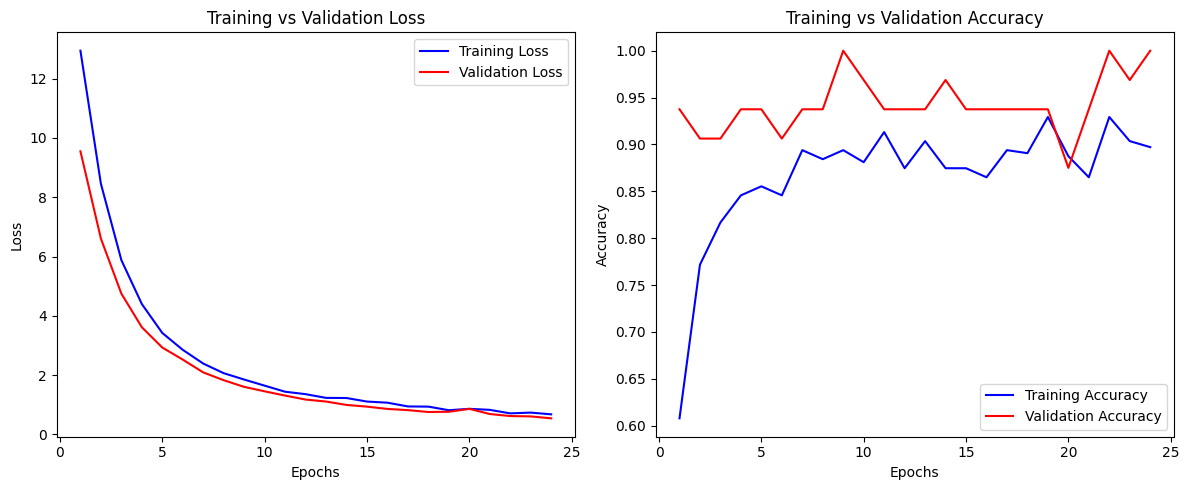

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Confusion Matrix**

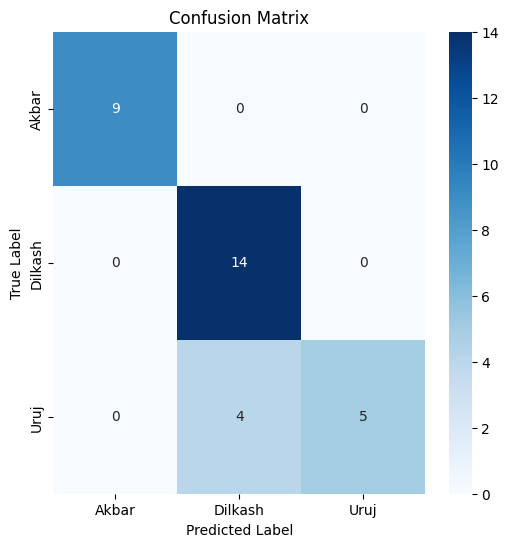

In [21]:
cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Effecient Net

In [22]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)

In [24]:
efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [25]:
history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5452 - loss: 11.6066 - val_accuracy: 0.8438 - val_loss: 8.5326
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7194 - loss: 8.0562 - val_accuracy: 0.9375 - val_loss: 5.9527
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7638 - loss: 5.5682 - val_accuracy: 0.8438 - val_loss: 4.1330
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7775 - loss: 3.9211 - val_accuracy: 0.7812 - val_loss: 3.0707
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8014 - loss: 2.8621 - val_accuracy: 0.7812 - val_loss: 2.3125
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8027 - loss: 2.1869 - val_accuracy: 0.9062 - val_loss: 1.7039
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7977 - loss: 1.8444 - val_accuracy: 0.9375 - val_loss: 1.4106
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8718 - loss: 1.3930 - val_accuracy: 0.9688 - v

In [26]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = efficientnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


Accuracy:  0.8438
Precision: 0.8665
Recall:    0.8438
F1-Score:  0.8455

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       0.91      0.71      0.80        14
        Uruj       0.67      0.89      0.76         9

    accuracy                           0.84        32
   macro avg       0.86      0.87      0.85        32
weighted avg       0.87      0.84      0.85        32



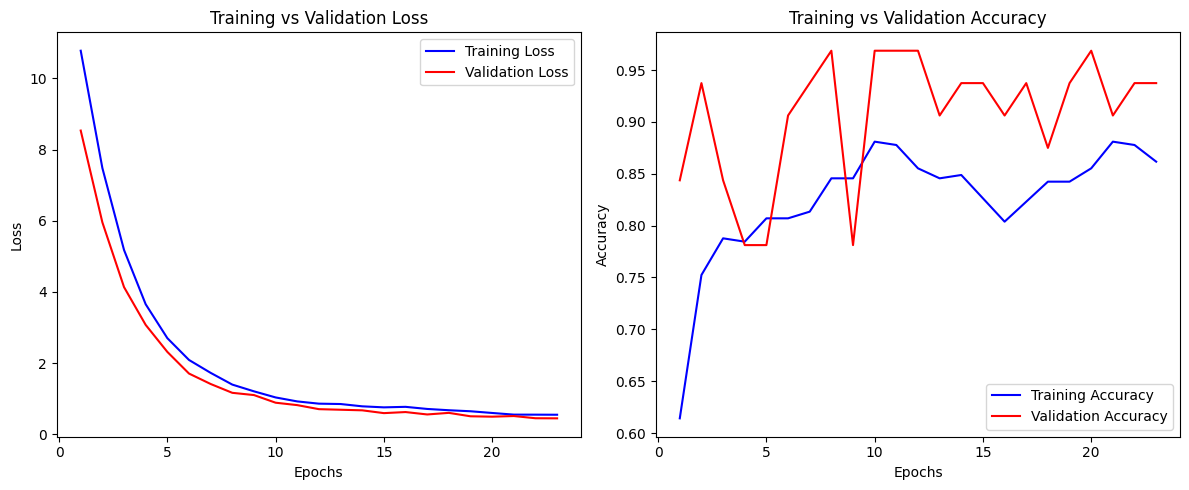

In [27]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

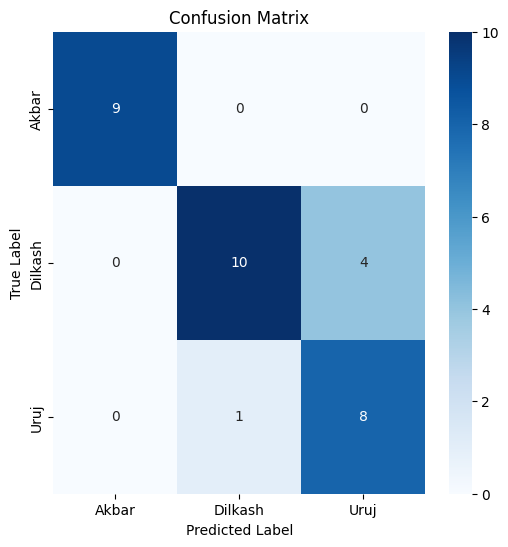

In [28]:
cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# MobileNet

In [29]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [30]:
FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

In [31]:
mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [32]:
history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 577ms/step - accuracy: 0.3685 - loss: 11.3608 - val_accuracy: 0.6562 - val_loss: 7.6362
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5999 - loss: 7.3402 - val_accuracy: 0.6562 - val_loss: 5.5266
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6430 - loss: 5.1679 - val_accuracy: 0.5938 - val_loss: 4.0965
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7126 - loss: 3.7798 - val_accuracy: 0.6875 - val_loss: 2.9966
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7723 - loss: 2.9143 - val_accuracy: 0.8438 - val_loss: 2.4423
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7793 - loss: 2.4180 - val_accuracy: 0.9062 - val_loss: 2.0769
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8288 - loss: 2.0496 - val_accuracy: 0.6875 - val_loss: 2.0436
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7636 - loss: 1.9844 - val_accuracy: 0.8438 

In [33]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


Accuracy:  0.8438
Precision: 0.8849
Recall:    0.8438
F1-Score:  0.8255

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       0.74      1.00      0.85        14
        Uruj       1.00      0.44      0.62         9

    accuracy                           0.84        32
   macro avg       0.91      0.81      0.82        32
weighted avg       0.88      0.84      0.83        32



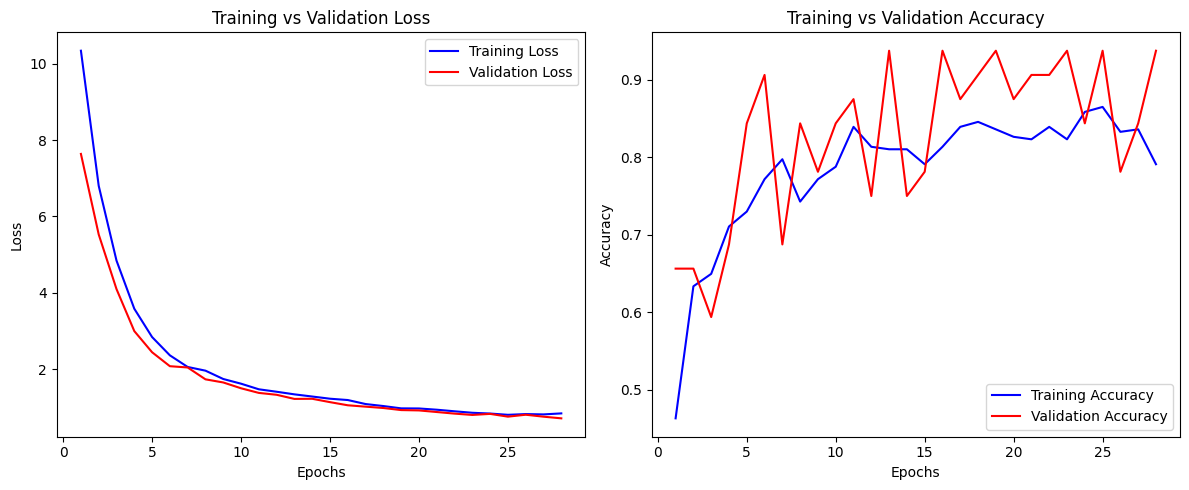

In [34]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

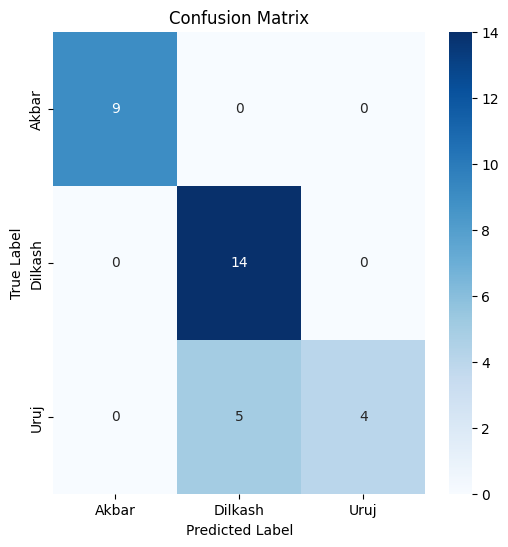

In [35]:
cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# GoogleNet

In [43]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.8
val_split = 0.1
test_split = 0.1

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Total images: 375
Train: 300, Val: 37, Test: 38


In [44]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

In [45]:
num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)


Epoch [1/50] Train Loss: 1.0830 Train Acc: 0.4067 Val Loss: 1.0362 Val Acc: 0.7838
Epoch [2/50] Train Loss: 1.0034 Train Acc: 0.5833 Val Loss: 0.9567 Val Acc: 0.8649
Epoch [3/50] Train Loss: 0.8953 Train Acc: 0.6833 Val Loss: 0.8793 Val Acc: 0.7568
Epoch [4/50] Train Loss: 0.8375 Train Acc: 0.7033 Val Loss: 0.7888 Val Acc: 0.8919
Epoch [5/50] Train Loss: 0.7775 Train Acc: 0.7467 Val Loss: 0.6934 Val Acc: 0.8919
Epoch [6/50] Train Loss: 0.7527 Train Acc: 0.7600 Val Loss: 0.6605 Val Acc: 0.8919
Epoch [7/50] Train Loss: 0.6986 Train Acc: 0.7600 Val Loss: 0.5998 Val Acc: 0.9189
Epoch [8/50] Train Loss: 0.6204 Train Acc: 0.7767 Val Loss: 0.5776 Val Acc: 0.9189
Epoch [9/50] Train Loss: 0.5757 Train Acc: 0.8367 Val Loss: 0.5252 Val Acc: 0.9459
Epoch [10/50] Train Loss: 0.5922 Train Acc: 0.7700 Val Loss: 0.4945 Val Acc: 0.9189
Epoch [11/50] Train Loss: 0.5456 Train Acc: 0.8367 Val Loss: 0.4607 Val Acc: 0.9189
Epoch [12/50] Train Loss: 0.5111 Train Acc: 0.8500 Val Loss: 0.4699 Val Acc: 0.9459
E

In [49]:
googlenet.eval()  
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = googlenet(images)  
        _, preds = torch.max(outputs, 1) 

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

Accuracy:  0.7895
Precision: 0.7982
Recall:    0.7895
F1-Score:  0.7930

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      0.92      0.96        13
     Dilkash       0.71      0.71      0.71        14
        Uruj       0.67      0.73      0.70        11

    accuracy                           0.79        38
   macro avg       0.79      0.79      0.79        38
weighted avg       0.80      0.79      0.79        38



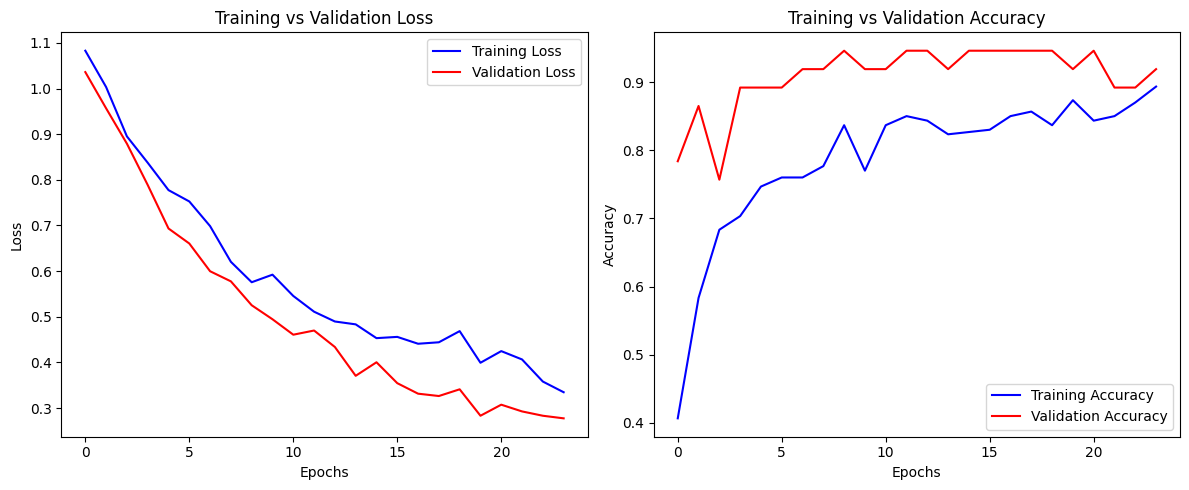

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

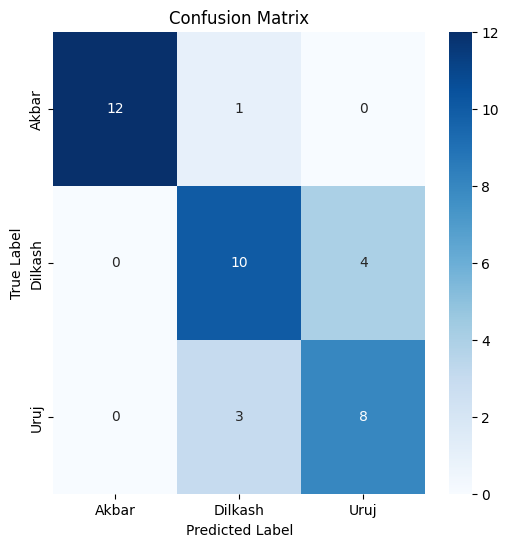

In [51]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Comparison

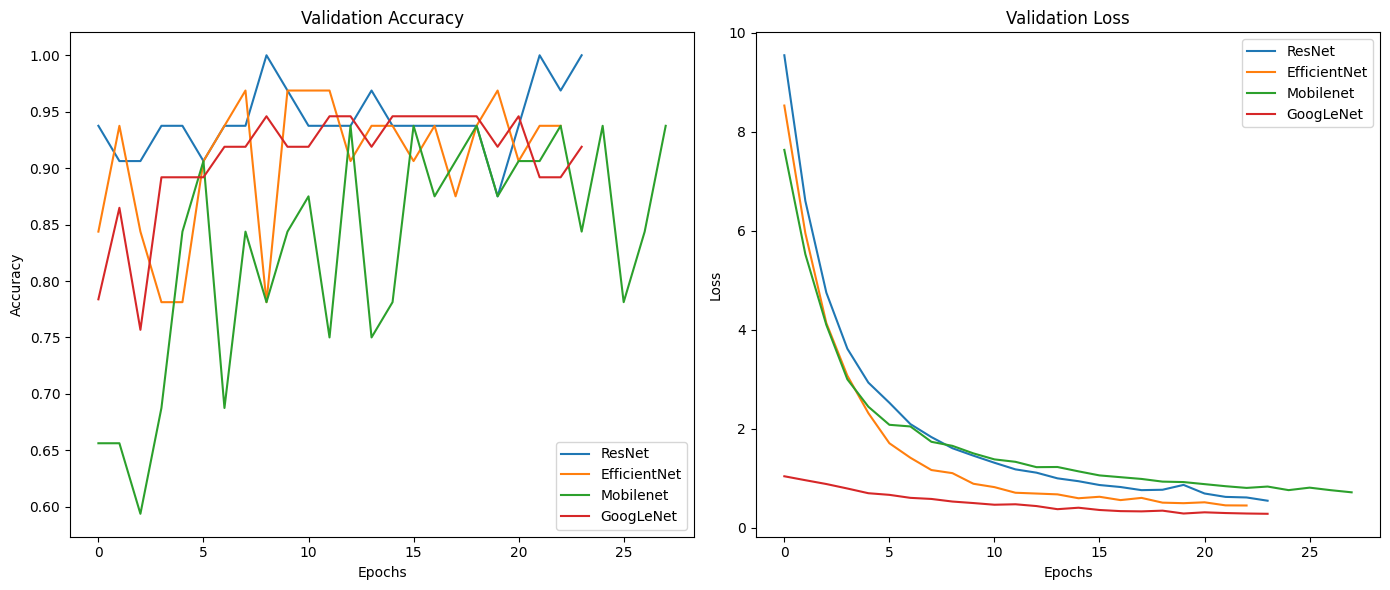

In [52]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


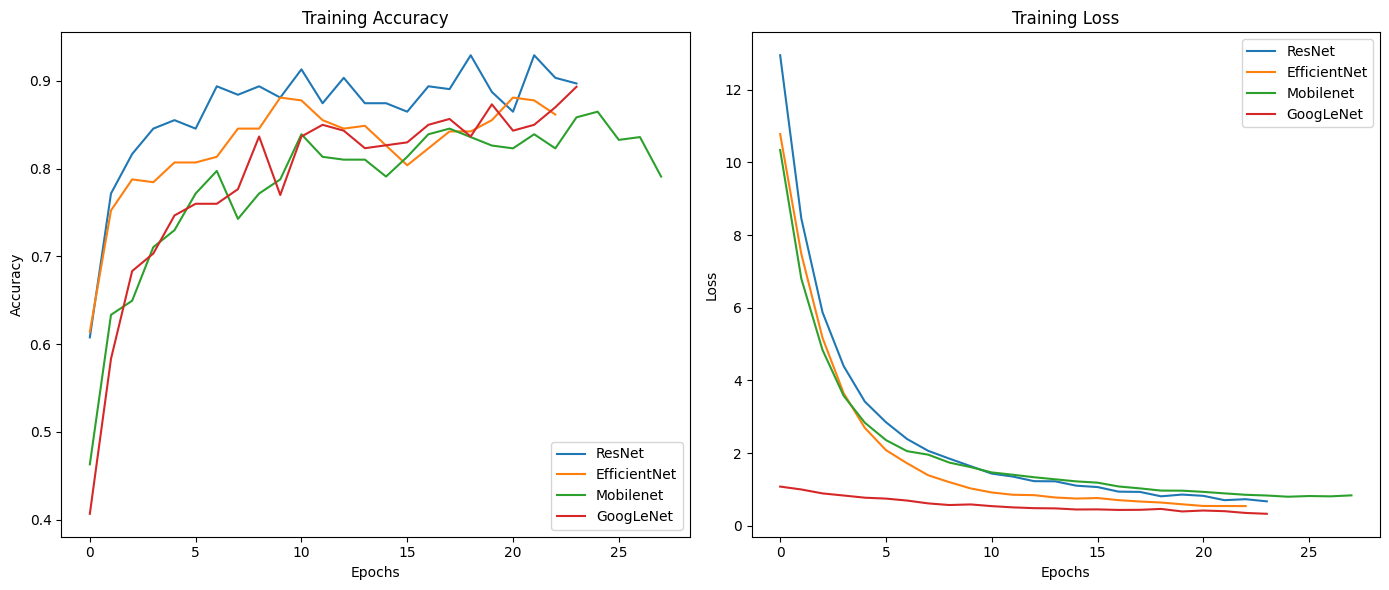

In [53]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test, Train (80,20)

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

In [57]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [58]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False


FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 999ms/step - accuracy: 0.4827 - loss: 15.0872 - val_accuracy: 0.7188 - val_loss: 10.1898
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6842 - loss: 9.5480 - val_accuracy: 0.6875 - val_loss: 7.1964
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7065 - loss: 6.8795 - val_accuracy: 0.7812 - val_loss: 5.3599
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7717 - loss: 5.1356 - val_accuracy: 0.8438 - val_loss: 4.1113
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7717 - loss: 4.0895 - val_accuracy: 0.8750 - val_loss: 3.3576
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8877 - loss: 3.2734 - val_accuracy: 0.9688 - val_loss: 2.8773
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8636 - loss: 2.8361 - val_accuracy: 0.9375 - val_loss: 2.4772
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8821 - loss: 2.4743 - val_accuracy: 0.9375

Accuracy:  0.9375
Precision: 0.9375
Recall:    0.9375
F1-Score:  0.9375

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       0.93      0.93      0.93        14
        Uruj       0.89      0.89      0.89         9

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



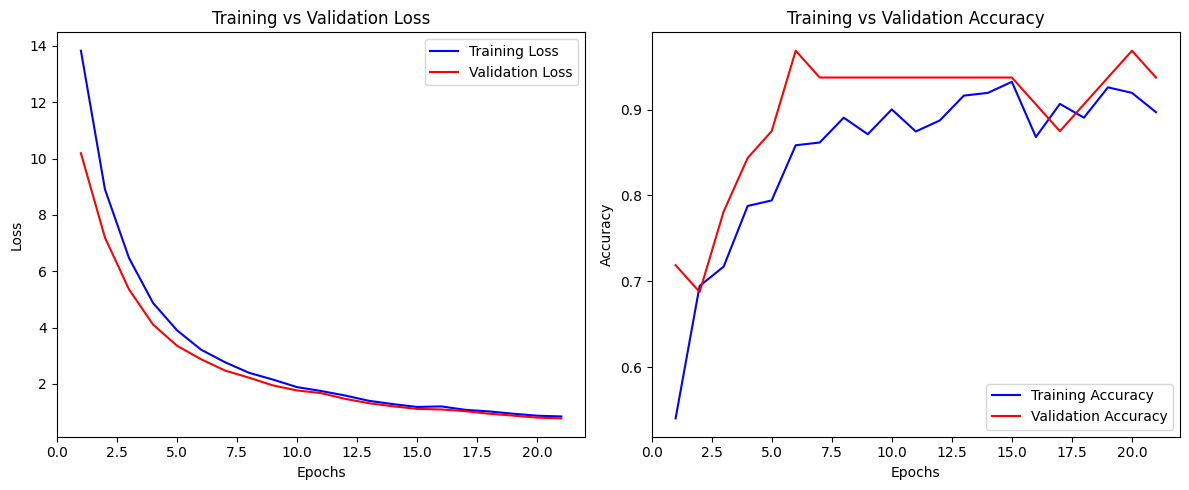

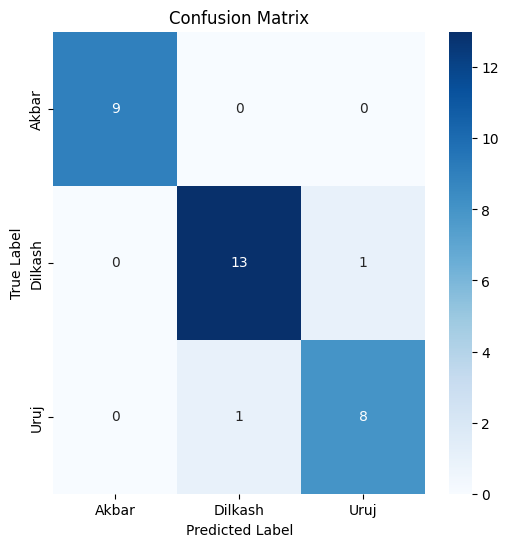

In [59]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [60]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)


efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5643 - loss: 11.6986 - val_accuracy: 0.6562 - val_loss: 8.9807
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7092 - loss: 8.2823 - val_accuracy: 0.8438 - val_loss: 6.2935
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7643 - loss: 5.8660 - val_accuracy: 0.9062 - val_loss: 4.4324
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8163 - loss: 4.1731 - val_accuracy: 0.7188 - val_loss: 3.3717
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7852 - loss: 3.1367 - val_accuracy: 0.9062 - val_loss: 2.4248
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8176 - loss: 2.4193 - val_accuracy: 0.9375 - val_loss: 1.9904
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8708 - loss: 1.9029 - val_accuracy: 0.5938 - val_loss: 2.0142
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8154 - loss: 1.6611 - val_accuracy: 0.9375 - v

Accuracy:  0.9062
Precision: 0.9065
Recall:    0.9062
F1-Score:  0.9051

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       0.87      0.93      0.90        14
        Uruj       0.88      0.78      0.82         9

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.91        32
weighted avg       0.91      0.91      0.91        32



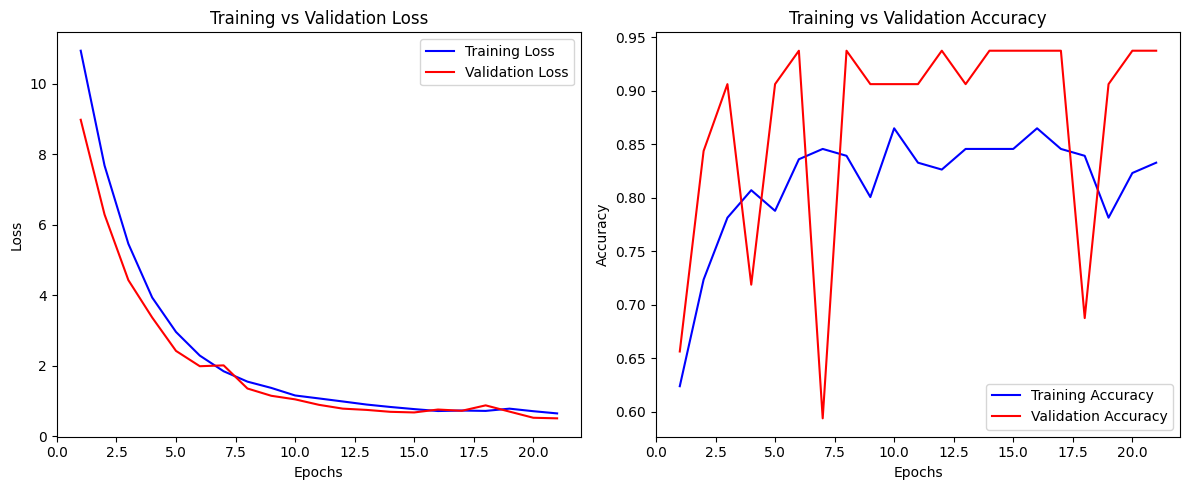

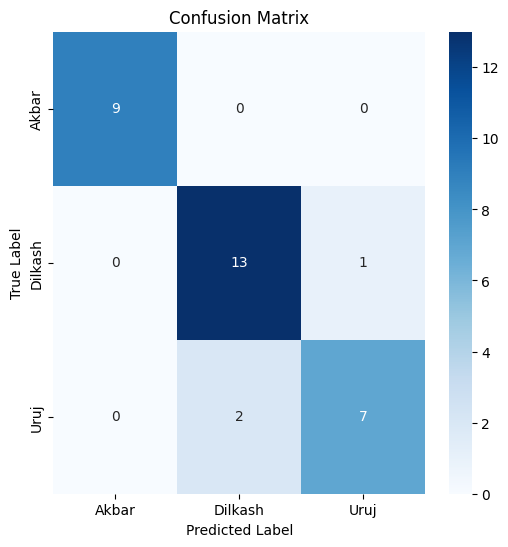

In [61]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = efficientnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [62]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 439ms/step - accuracy: 0.3932 - loss: 11.3848 - val_accuracy: 0.7188 - val_loss: 7.5845
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5814 - loss: 7.2409 - val_accuracy: 0.7812 - val_loss: 5.1934
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6850 - loss: 4.9658 - val_accuracy: 0.8125 - val_loss: 3.6971
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7193 - loss: 3.5545 - val_accuracy: 0.8125 - val_loss: 2.8511
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7780 - loss: 2.7791 - val_accuracy: 0.8125 - val_loss: 2.3332
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7531 - loss: 2.4252 - val_accuracy: 0.8438 - val_loss: 2.0527
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7504 - loss: 2.1419 - val_accuracy: 0.8125 - val_loss: 1.8581
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8020 - loss: 1.8540 - val_accuracy: 0.7812 

Accuracy:  0.9062
Precision: 0.9297
Recall:    0.9062
F1-Score:  0.9073

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00         9
     Dilkash       1.00      0.79      0.88        14
        Uruj       0.75      1.00      0.86         9

    accuracy                           0.91        32
   macro avg       0.92      0.93      0.91        32
weighted avg       0.93      0.91      0.91        32



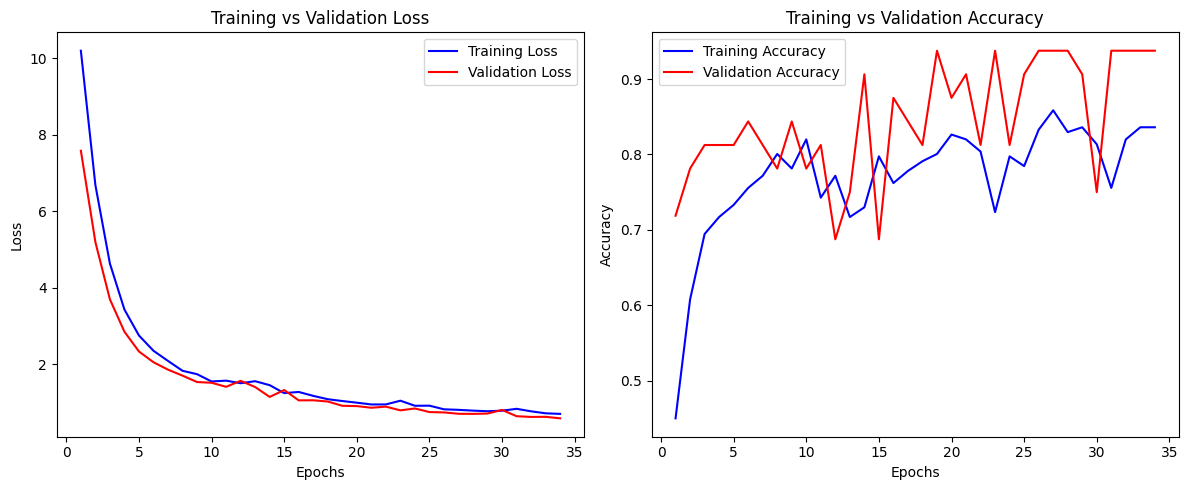

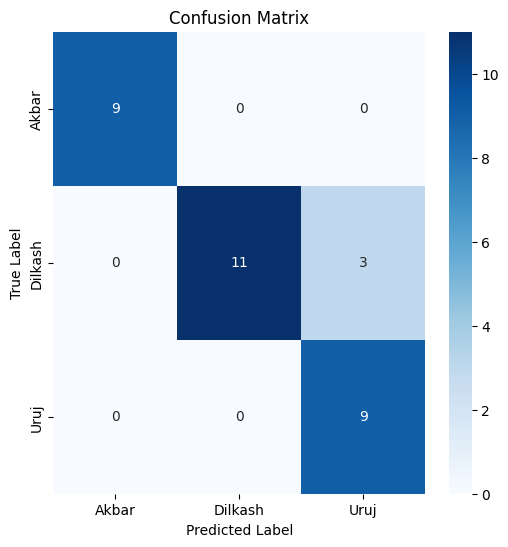

In [63]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [64]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.7
val_split = 0.1
test_split = 0.2

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")



Total images: 375
Train: 262, Val: 37, Test: 76


In [68]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  


In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)


googlenet.eval()  
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = googlenet(images)  
        _, preds = torch.max(outputs, 1) 

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

Epoch [1/50] Train Loss: 1.0910 Train Acc: 0.3740 Val Loss: 1.0902 Val Acc: 0.4054
Epoch [2/50] Train Loss: 0.9911 Train Acc: 0.6069 Val Loss: 1.0480 Val Acc: 0.4865
Epoch [3/50] Train Loss: 0.9085 Train Acc: 0.6794 Val Loss: 0.9449 Val Acc: 0.5946
Epoch [4/50] Train Loss: 0.8835 Train Acc: 0.7137 Val Loss: 0.8642 Val Acc: 0.6216
Epoch [5/50] Train Loss: 0.7917 Train Acc: 0.7176 Val Loss: 0.7834 Val Acc: 0.6486
Epoch [6/50] Train Loss: 0.7461 Train Acc: 0.7672 Val Loss: 0.7986 Val Acc: 0.6216
Epoch [7/50] Train Loss: 0.6830 Train Acc: 0.7939 Val Loss: 0.7316 Val Acc: 0.6486
Epoch [8/50] Train Loss: 0.6306 Train Acc: 0.8244 Val Loss: 0.6616 Val Acc: 0.6757
Epoch [9/50] Train Loss: 0.6325 Train Acc: 0.7710 Val Loss: 0.7249 Val Acc: 0.6216
Epoch [10/50] Train Loss: 0.6446 Train Acc: 0.7481 Val Loss: 0.6267 Val Acc: 0.7297
Epoch [11/50] Train Loss: 0.5518 Train Acc: 0.8397 Val Loss: 0.6175 Val Acc: 0.7027
Epoch [12/50] Train Loss: 0.5629 Train Acc: 0.7901 Val Loss: 0.7084 Val Acc: 0.6216
E

Accuracy:  0.7763
Precision: 0.8283
Recall:    0.7763
F1-Score:  0.7755

Classification Report:
              precision    recall  f1-score   support

       Akbar       0.95      0.88      0.91        24
     Dilkash       0.89      0.57      0.69        30
        Uruj       0.60      0.95      0.74        22

    accuracy                           0.78        76
   macro avg       0.82      0.80      0.78        76
weighted avg       0.83      0.78      0.78        76



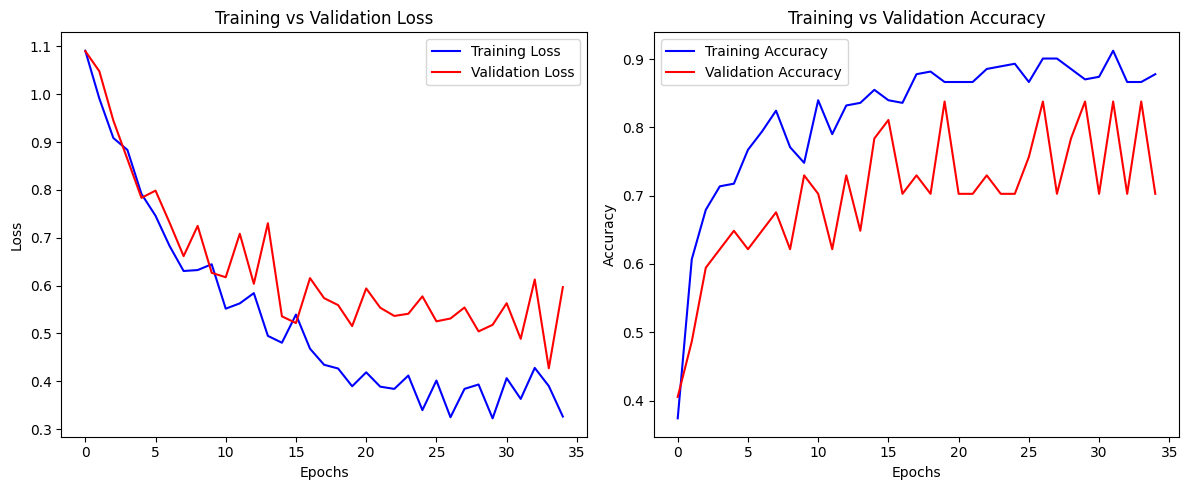

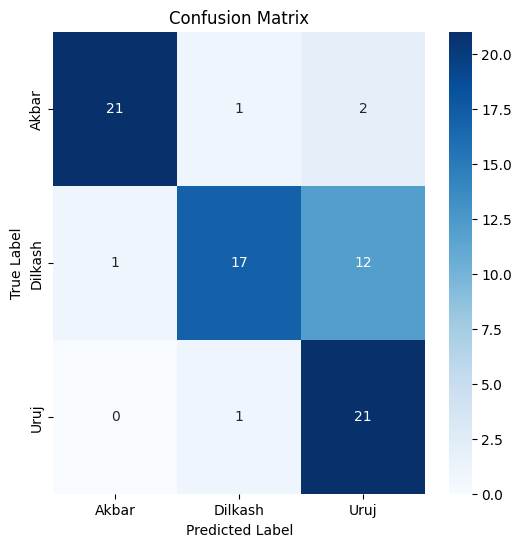

In [70]:
true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

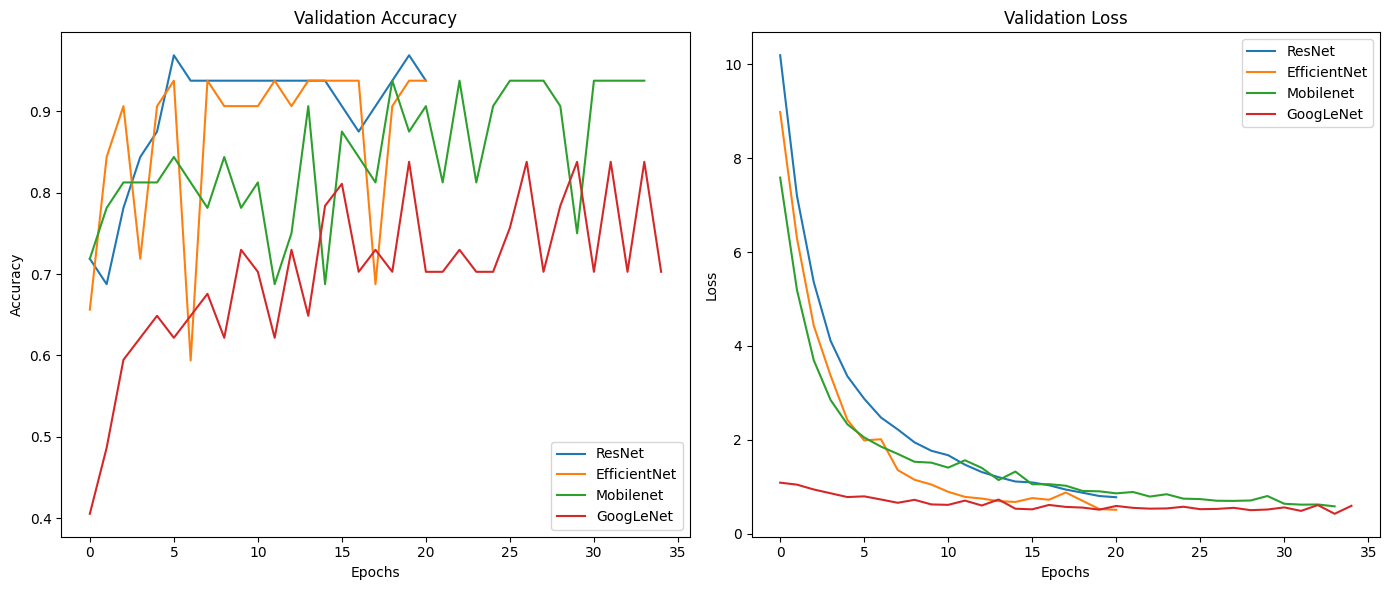

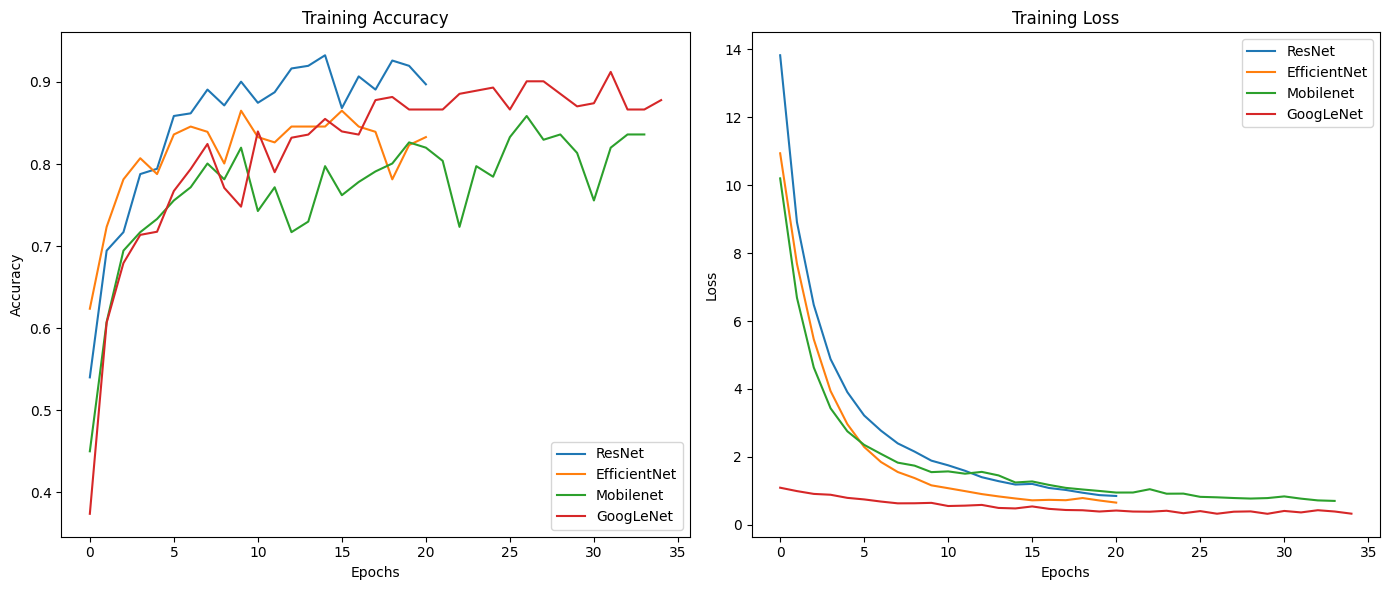

In [71]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)



Found 375 files belonging to 3 classes.


In [73]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False


FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5023 - loss: 14.4544 - val_accuracy: 0.6875 - val_loss: 10.4593
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6904 - loss: 10.1414 - val_accuracy: 0.7188 - val_loss: 7.8165
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7140 - loss: 7.5738 - val_accuracy: 0.8750 - val_loss: 5.7278
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7913 - loss: 5.7153 - val_accuracy: 0.9375 - val_loss: 4.4882
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8127 - loss: 4.4943 - val_accuracy: 0.8750 - val_loss: 3.8400
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7918 - loss: 3.8329 - val_accuracy: 0.8438 - val_loss: 3.2219
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8960 - loss: 3.1015 - val_accuracy: 0.9375 - val_loss: 2.7607
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8572 - loss: 2.8558 - val_accuracy: 0.9375 - val_loss: 2.479

Accuracy:  0.9062
Precision: 0.9064
Recall:    0.9062
F1-Score:  0.9062

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        33
     Dilkash       0.85      0.88      0.86        32
        Uruj       0.87      0.84      0.85        31

    accuracy                           0.91        96
   macro avg       0.91      0.90      0.90        96
weighted avg       0.91      0.91      0.91        96



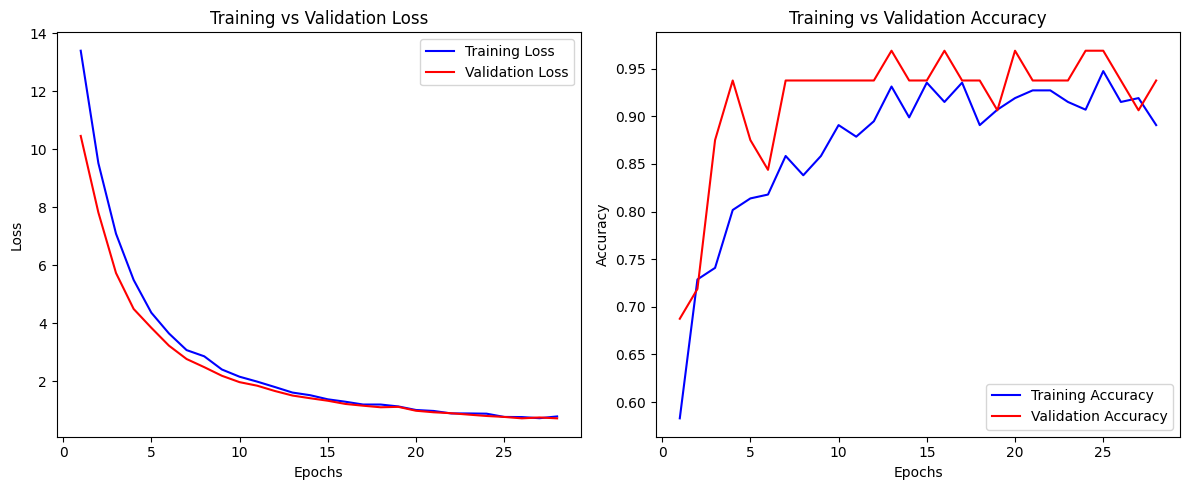

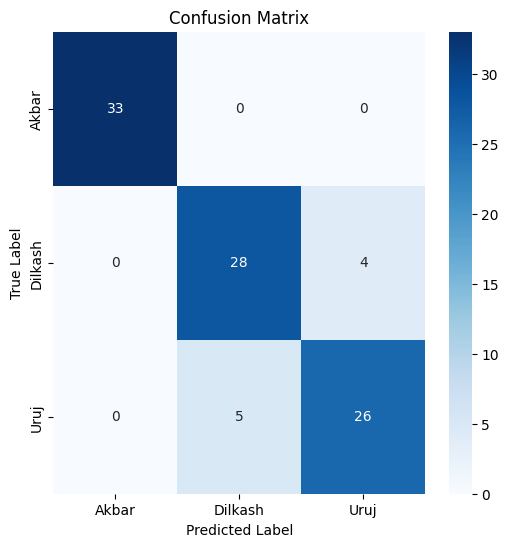

In [74]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [75]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)


efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.4842 - loss: 11.9625 - val_accuracy: 0.6875 - val_loss: 9.8705
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7385 - loss: 9.1154 - val_accuracy: 0.8438 - val_loss: 7.3934
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7194 - loss: 7.0918 - val_accuracy: 0.8438 - val_loss: 5.6217
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8140 - loss: 5.4183 - val_accuracy: 0.8438 - val_loss: 4.3794
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8070 - loss: 4.2336 - val_accuracy: 0.8750 - val_loss: 3.4331
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8498 - loss: 3.3132 - val_accuracy: 0.8750 - val_loss: 2.8174
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8484 - loss: 2.7063 - val_accuracy: 0.8750 - val_loss: 2.2769
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8407 - loss: 2.2603 - val_accuracy: 0.9062 - val_loss: 1.9274


Accuracy:  0.8542
Precision: 0.8995
Recall:    0.8542
F1-Score:  0.8472

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        33
     Dilkash       1.00      0.56      0.72        32
        Uruj       0.69      1.00      0.82        31

    accuracy                           0.85        96
   macro avg       0.90      0.85      0.85        96
weighted avg       0.90      0.85      0.85        96



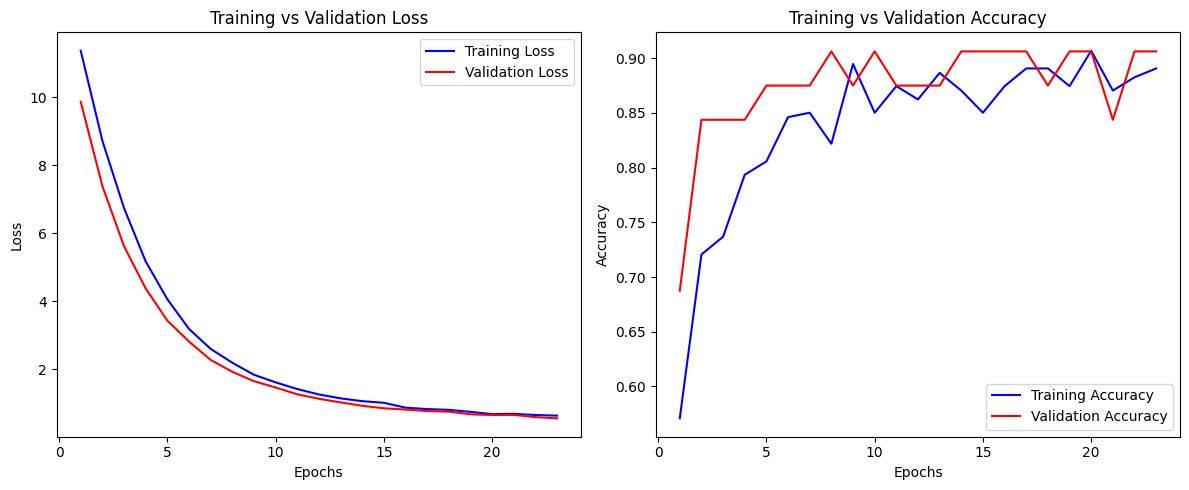

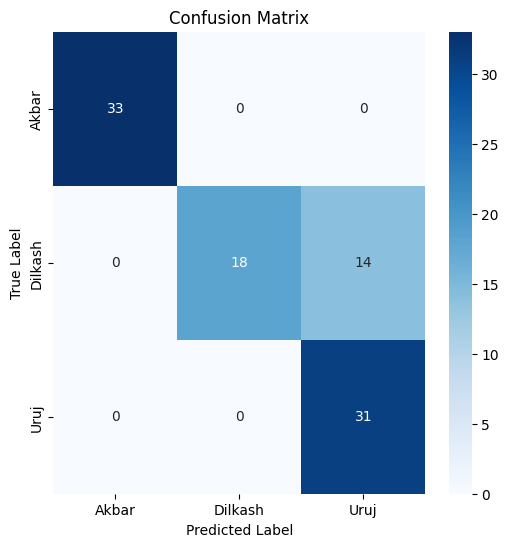

In [76]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = efficientnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [77]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 558ms/step - accuracy: 0.3731 - loss: 11.1975 - val_accuracy: 0.6250 - val_loss: 8.1176
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5897 - loss: 8.0028 - val_accuracy: 0.6875 - val_loss: 6.2325
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6613 - loss: 6.0208 - val_accuracy: 0.8750 - val_loss: 4.3751
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6788 - loss: 4.5242 - val_accuracy: 0.7500 - val_loss: 3.4331
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7332 - loss: 3.4971 - val_accuracy: 0.7500 - val_loss: 2.7847
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7836 - loss: 2.8686 - val_accuracy: 0.7500 - val_loss: 2.4347
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7630 - loss: 2.4720 - val_accuracy: 0.7500 - val_loss: 2.1798
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7627 - loss: 2.2616 - val_accuracy: 0.9375 - val_loss: 1.89

Accuracy:  0.8958
Precision: 0.8968
Recall:    0.8958
F1-Score:  0.8958

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      1.00      1.00        33
     Dilkash       0.87      0.81      0.84        32
        Uruj       0.82      0.87      0.84        31

    accuracy                           0.90        96
   macro avg       0.89      0.89      0.89        96
weighted avg       0.90      0.90      0.90        96



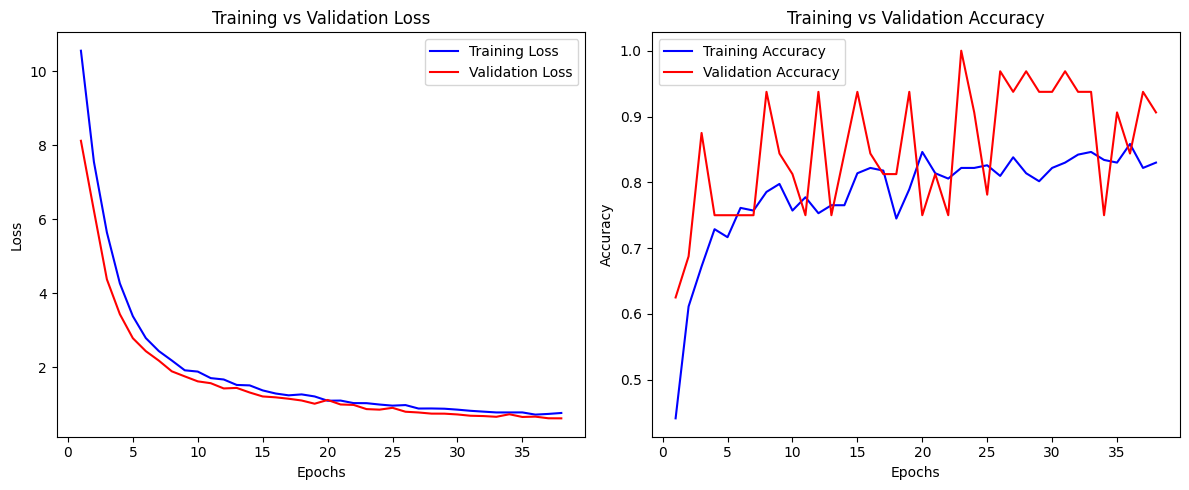

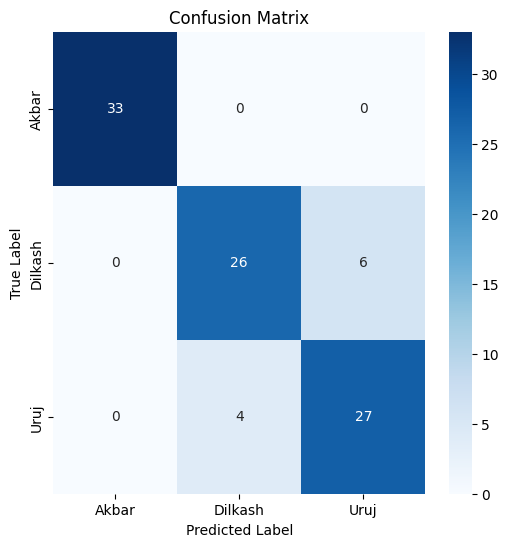

In [78]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [79]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.7
val_split = 0.1
test_split = 0.2

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Total images: 375
Train: 262, Val: 37, Test: 76


In [80]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)



Epoch [1/50] Train Loss: 1.0743 Train Acc: 0.3855 Val Loss: 1.0221 Val Acc: 0.5946
Epoch [2/50] Train Loss: 0.9913 Train Acc: 0.5916 Val Loss: 0.9707 Val Acc: 0.6757
Epoch [3/50] Train Loss: 0.9246 Train Acc: 0.6947 Val Loss: 0.9127 Val Acc: 0.6757
Epoch [4/50] Train Loss: 0.8339 Train Acc: 0.7061 Val Loss: 0.8564 Val Acc: 0.6486
Epoch [5/50] Train Loss: 0.7758 Train Acc: 0.7328 Val Loss: 0.8456 Val Acc: 0.7838
Epoch [6/50] Train Loss: 0.7355 Train Acc: 0.7634 Val Loss: 0.8288 Val Acc: 0.7838
Epoch [7/50] Train Loss: 0.6921 Train Acc: 0.7901 Val Loss: 0.7861 Val Acc: 0.7568
Epoch [8/50] Train Loss: 0.6500 Train Acc: 0.7863 Val Loss: 0.7761 Val Acc: 0.8108
Epoch [9/50] Train Loss: 0.6626 Train Acc: 0.7672 Val Loss: 0.7402 Val Acc: 0.7838
Epoch [10/50] Train Loss: 0.6111 Train Acc: 0.8053 Val Loss: 0.7449 Val Acc: 0.7838
Epoch [11/50] Train Loss: 0.5940 Train Acc: 0.7977 Val Loss: 0.7297 Val Acc: 0.7838
Epoch [12/50] Train Loss: 0.5750 Train Acc: 0.7863 Val Loss: 0.7028 Val Acc: 0.8108
E

Accuracy:  0.8553
Precision: 0.8674
Recall:    0.8553
F1-Score:  0.8565

Classification Report:
              precision    recall  f1-score   support

       Akbar       0.97      0.94      0.95        32
     Dilkash       0.71      0.87      0.78        23
        Uruj       0.88      0.71      0.79        21

    accuracy                           0.86        76
   macro avg       0.85      0.84      0.84        76
weighted avg       0.87      0.86      0.86        76



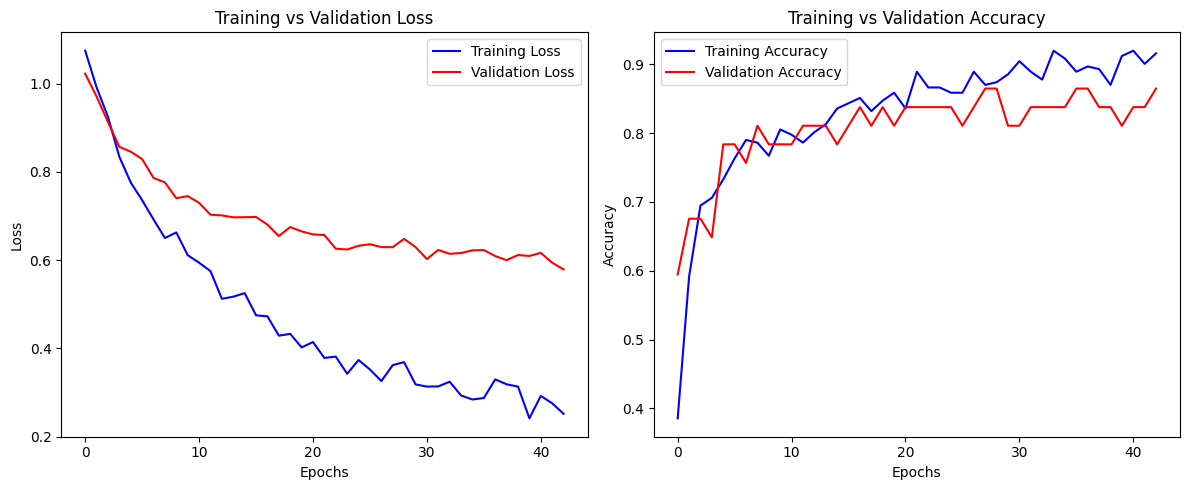

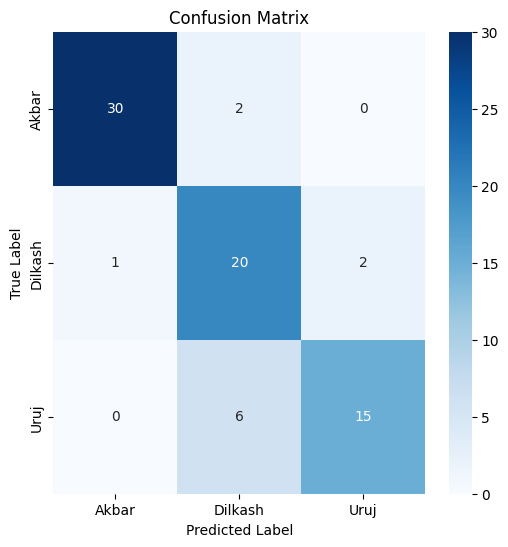

In [81]:
googlenet.eval()  
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = googlenet(images)  
        _, preds = torch.max(outputs, 1) 

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


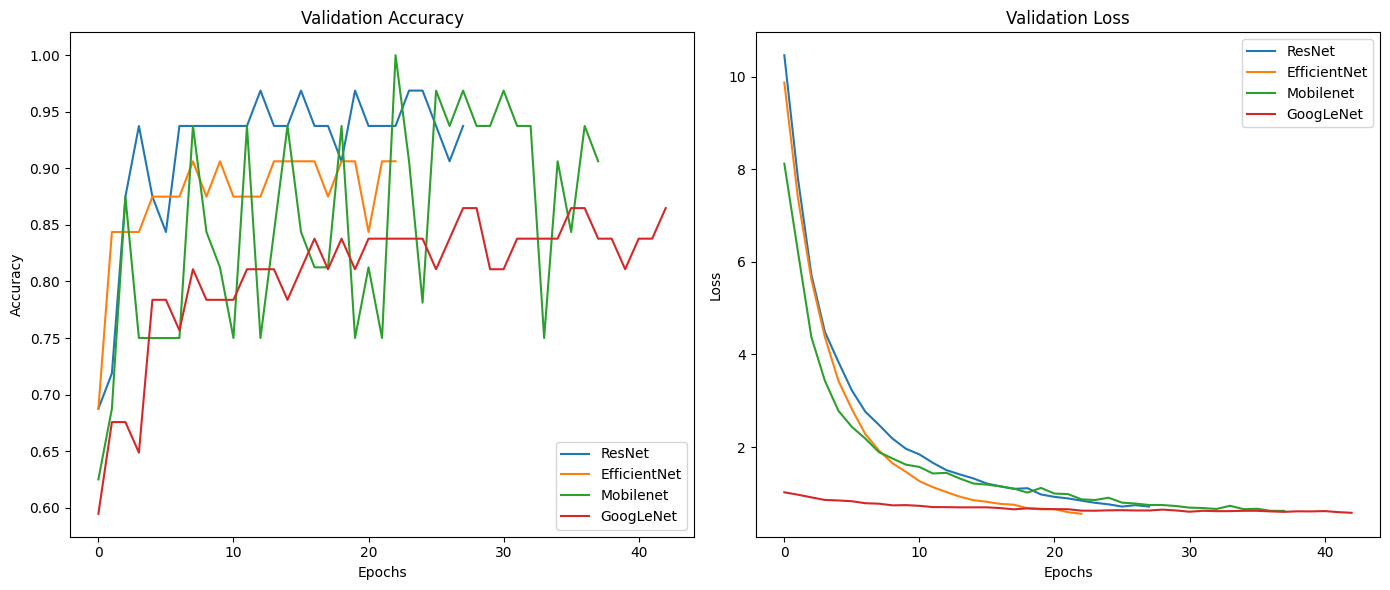

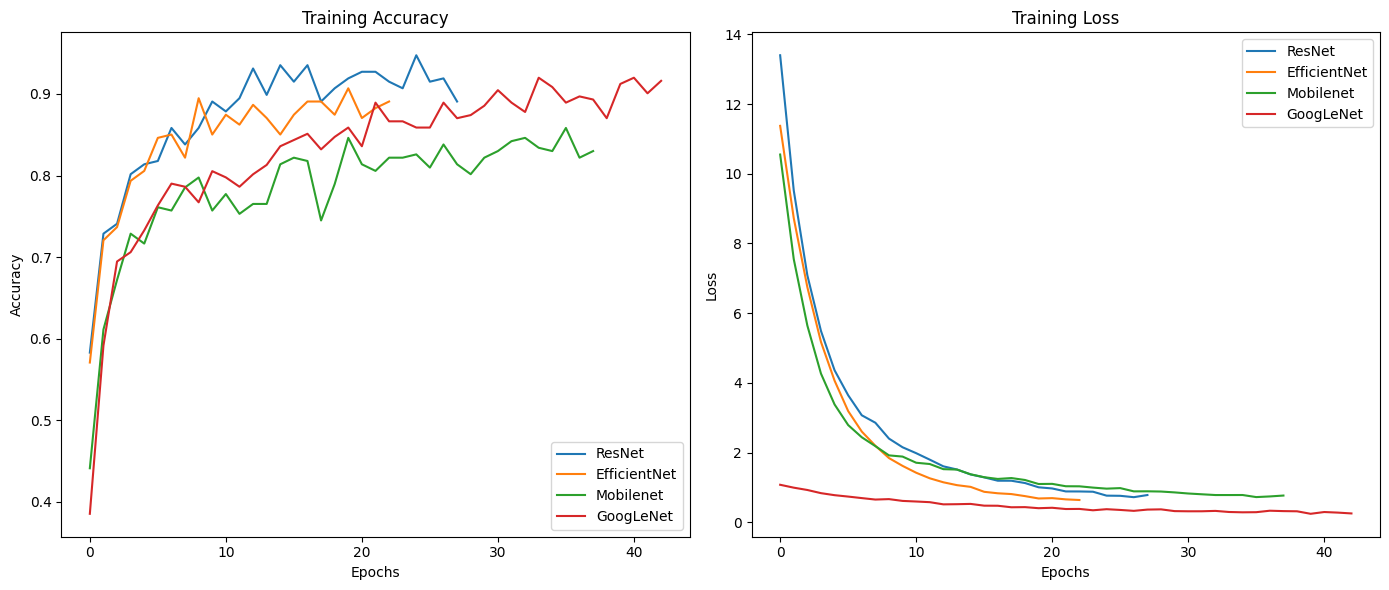

In [82]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [88]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.1, test_split=0.4, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 375 files belonging to 3 classes.


In [89]:
resnet= ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = input_shape 
                 )


for layer in resnet.layers:
    layer.trainable = False


FC_Head = lw(resnet, 3)
resnet= Model(inputs =resnet.input, outputs = FC_Head)

resnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history = resnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping] )


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.4660 - loss: 15.7639 - val_accuracy: 0.6562 - val_loss: 11.8519
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6990 - loss: 11.0018 - val_accuracy: 0.8438 - val_loss: 8.4170
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7585 - loss: 8.2081 - val_accuracy: 0.8125 - val_loss: 6.5808
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8657 - loss: 6.2284 - val_accuracy: 0.8750 - val_loss: 5.2478
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8064 - loss: 5.1092 - val_accuracy: 0.8438 - val_loss: 4.2638
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8646 - loss: 4.1640 - val_accuracy: 0.9062 - val_loss: 3.6647
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8573 - loss: 3.5257 - val_accuracy: 0.8438 - val_loss: 3.1566
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9295 - loss: 3.0339 - val_accuracy: 0.8750 - val_loss: 2.787

Accuracy:  0.9141
Precision: 0.9180
Recall:    0.9141
F1-Score:  0.9149

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      0.92      0.96        48
     Dilkash       0.86      0.88      0.87        42
        Uruj       0.88      0.95      0.91        38

    accuracy                           0.91       128
   macro avg       0.91      0.91      0.91       128
weighted avg       0.92      0.91      0.91       128



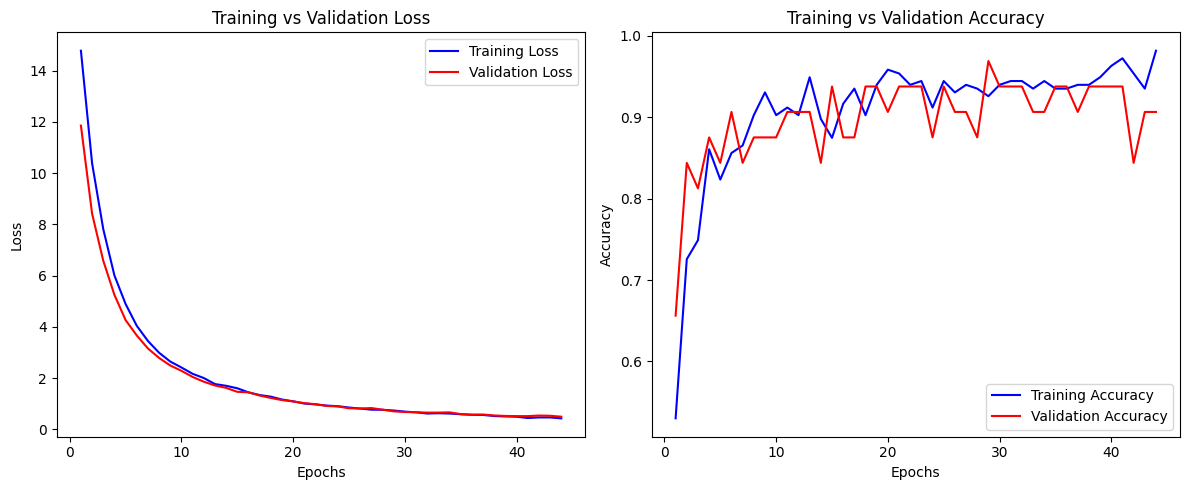

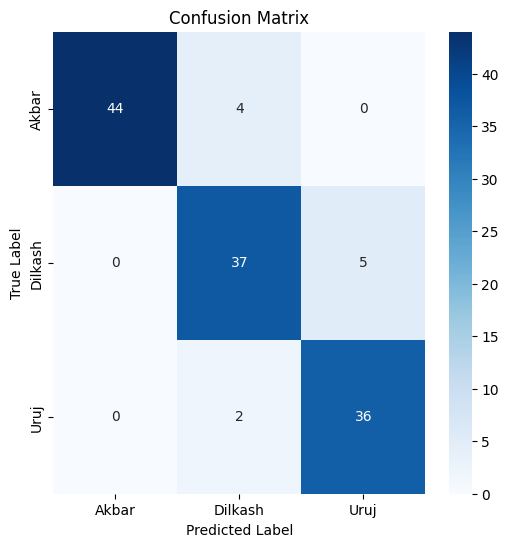

In [91]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = resnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [92]:
efficientnet= EfficientNetB0(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in efficientnet.layers:
    layer.trainable = False

FC_Head2 = lw(efficientnet, 3)
efficientnet= Model(inputs =efficientnet.input, outputs = FC_Head2)


efficientnet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


history2 = efficientnet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5123 - loss: 11.7591 - val_accuracy: 0.8438 - val_loss: 9.6234
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7564 - loss: 9.1647 - val_accuracy: 0.8438 - val_loss: 7.4702
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7589 - loss: 7.2172 - val_accuracy: 0.7500 - val_loss: 5.8646
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8242 - loss: 5.5537 - val_accuracy: 0.7812 - val_loss: 4.5048
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8520 - loss: 4.2683 - val_accuracy: 0.8750 - val_loss: 3.5311
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8335 - loss: 3.4577 - val_accuracy: 0.9062 - val_loss: 2.8224
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8405 - loss: 2.7580 - val_accuracy: 0.8750 - val_loss: 2.3000
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8373 - loss: 2.3067 - val_accuracy: 0.7812 - val_loss: 1.9826


Accuracy:  0.8672
Precision: 0.8881
Recall:    0.8672
F1-Score:  0.8636

Classification Report:
              precision    recall  f1-score   support

       Akbar       0.98      0.98      0.98        48
     Dilkash       0.93      0.64      0.76        42
        Uruj       0.73      0.97      0.83        38

    accuracy                           0.87       128
   macro avg       0.88      0.87      0.86       128
weighted avg       0.89      0.87      0.86       128



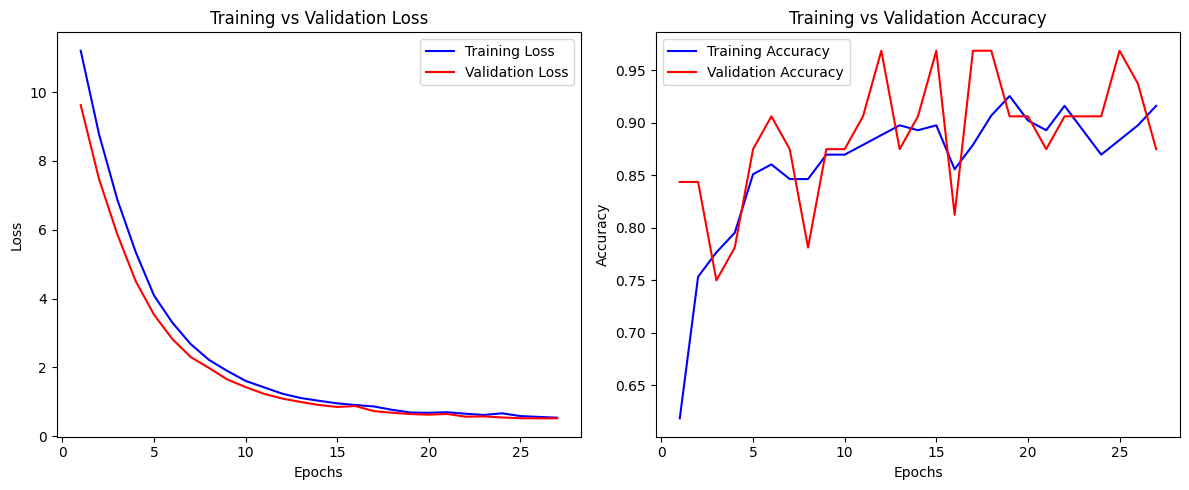

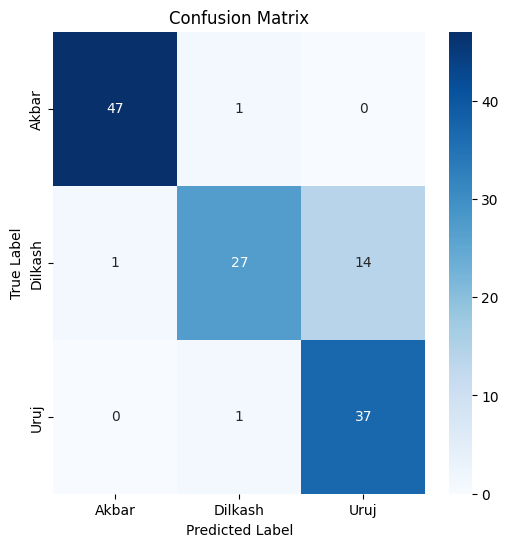

In [94]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = efficientnet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [95]:
mobilenet= MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (224, 224, 3)
                 )


for layer in mobilenet.layers:
    layer.trainable = False

FC_Head3 = lw(mobilenet, 3)
mobilenet= Model(inputs =mobilenet.input, outputs = FC_Head3)

mobilenet.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

history3 = mobilenet.fit( 
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[early_stopping])


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 627ms/step - accuracy: 0.3471 - loss: 11.8205 - val_accuracy: 0.5000 - val_loss: 8.9498
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5623 - loss: 8.3193 - val_accuracy: 0.8125 - val_loss: 6.3424
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6531 - loss: 6.1867 - val_accuracy: 0.7500 - val_loss: 4.9437
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6762 - loss: 4.9336 - val_accuracy: 0.8750 - val_loss: 3.7284
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7390 - loss: 3.8965 - val_accuracy: 0.9375 - val_loss: 3.0245
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7804 - loss: 3.1081 - val_accuracy: 0.8438 - val_loss: 2.6334
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7478 - loss: 2.6984 - val_accuracy: 0.8438 - val_loss: 2.3092
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7941 - loss: 2.3219 - val_accuracy: 0.9062 - val_loss: 1.978

Accuracy:  0.7969
Precision: 0.8314
Recall:    0.7969
F1-Score:  0.7838

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      0.98      0.99        48
     Dilkash       0.63      0.93      0.75        42
        Uruj       0.84      0.42      0.56        38

    accuracy                           0.80       128
   macro avg       0.82      0.78      0.77       128
weighted avg       0.83      0.80      0.78       128



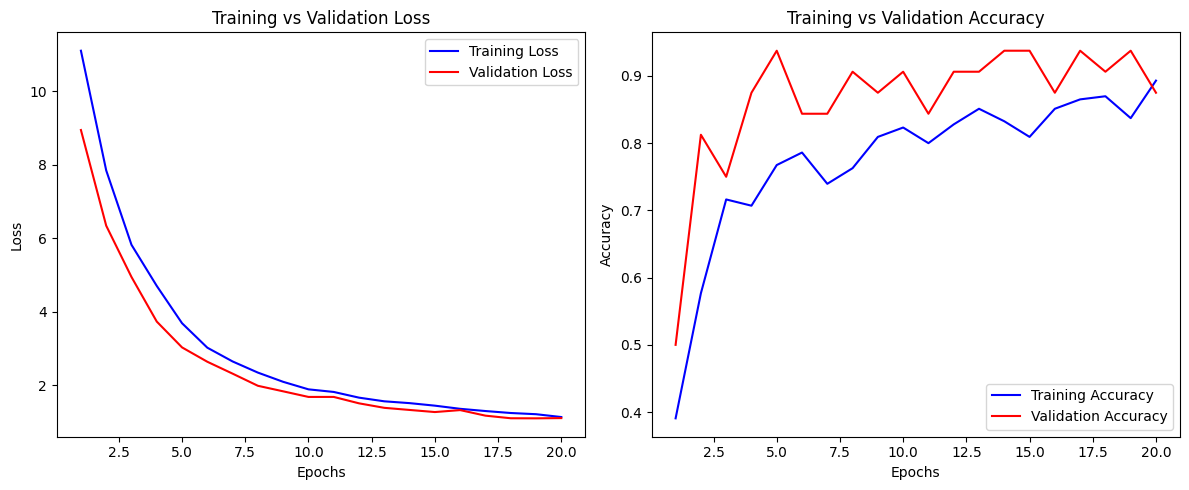

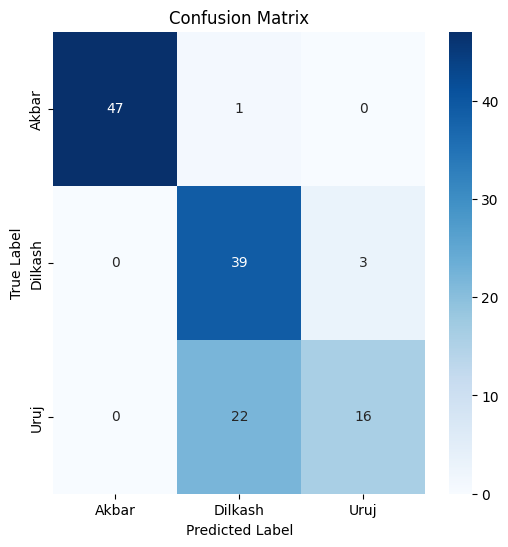

In [96]:
true_labels = []
predictions = []

for images, labels in test_ds:
    true_labels.extend(labels.numpy())  # shape: (batch_size,)
    
    preds = mobilenet.predict(images, verbose=0)  # shape: (batch_size, num_classes)
    preds = np.argmax(preds, axis=1)  # Get the predicted class index
    predictions.extend(preds)

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Metrics for multi-class classification
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

class_names = ['Akbar','Dilkash', 'Uruj']  

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [98]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  
])


data_dir = "/kaggle/input/wheatvarieties/Wheat varieties dataset-20240912T042219Z-001/Wheat varieties dataset"
dataset = datasets.ImageFolder(data_dir, transform=transform)

train_split = 0.6
val_split = 0.1
test_split = 0.3

train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total images: {len(dataset)}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Total images: 375
Train: 225, Val: 37, Test: 113


In [100]:
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1)

for param in googlenet.parameters():
    param.requires_grad = False

num_classes = 3
googlenet.fc = nn.Sequential(
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(1024, num_classes)
)

googlenet.aux_logits = False  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
googlenet = googlenet.to(device)


googlenet = googlenet.to(device)

optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

num_epochs=50
best_val_acc = 0.0
epochs_no_improve = 0
patience = 15 
best_model_wts = None

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    googlenet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train 

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    googlenet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = googlenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct_val / total_val

    # Save validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} "
          f"Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} "
          f"Val Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        best_model_wts = googlenet.state_dict() 
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break

if best_model_wts is not None:
    googlenet.load_state_dict(best_model_wts)



Epoch [1/50] Train Loss: 1.0737 Train Acc: 0.3733 Val Loss: 1.0241 Val Acc: 0.7027
Epoch [2/50] Train Loss: 1.0314 Train Acc: 0.5778 Val Loss: 0.9407 Val Acc: 0.8108
Epoch [3/50] Train Loss: 0.9479 Train Acc: 0.6178 Val Loss: 0.8779 Val Acc: 0.7838
Epoch [4/50] Train Loss: 0.9482 Train Acc: 0.7422 Val Loss: 0.8045 Val Acc: 0.7838
Epoch [5/50] Train Loss: 0.8790 Train Acc: 0.7511 Val Loss: 0.7789 Val Acc: 0.8108
Epoch [6/50] Train Loss: 0.8983 Train Acc: 0.7378 Val Loss: 0.7029 Val Acc: 0.8378
Epoch [7/50] Train Loss: 0.8651 Train Acc: 0.7467 Val Loss: 0.6721 Val Acc: 0.8378
Epoch [8/50] Train Loss: 0.7872 Train Acc: 0.7689 Val Loss: 0.6538 Val Acc: 0.8108
Epoch [9/50] Train Loss: 0.8049 Train Acc: 0.7644 Val Loss: 0.6232 Val Acc: 0.8919
Epoch [10/50] Train Loss: 0.7081 Train Acc: 0.7911 Val Loss: 0.5894 Val Acc: 0.8649
Epoch [11/50] Train Loss: 0.6555 Train Acc: 0.8044 Val Loss: 0.5783 Val Acc: 0.8649
Epoch [12/50] Train Loss: 0.7053 Train Acc: 0.7778 Val Loss: 0.5599 Val Acc: 0.8378
E

Accuracy:  0.8053
Precision: 0.8172
Recall:    0.8053
F1-Score:  0.8011

Classification Report:
              precision    recall  f1-score   support

       Akbar       1.00      0.94      0.97        32
     Dilkash       0.79      0.58      0.67        38
        Uruj       0.71      0.91      0.80        43

    accuracy                           0.81       113
   macro avg       0.83      0.81      0.81       113
weighted avg       0.82      0.81      0.80       113



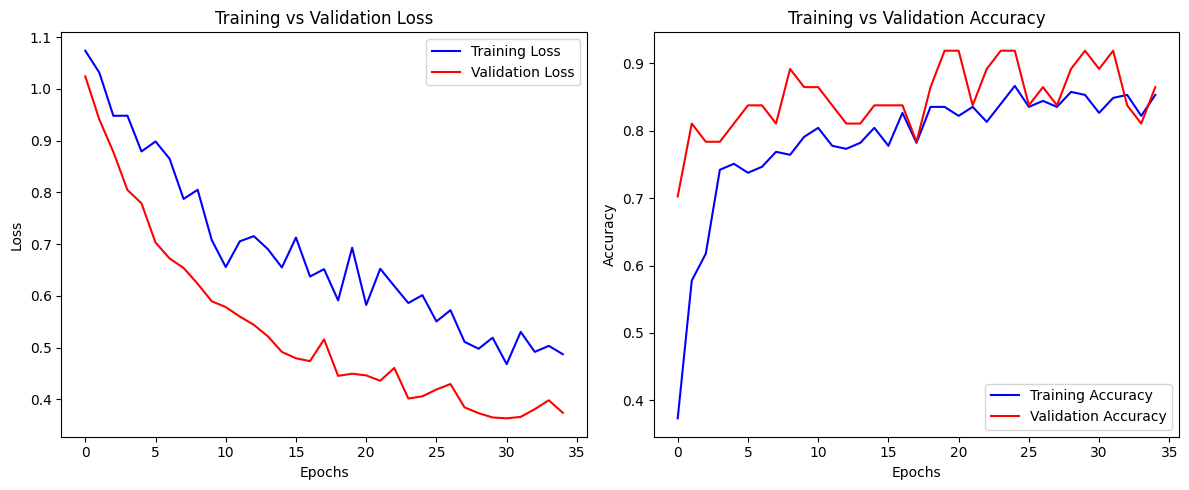

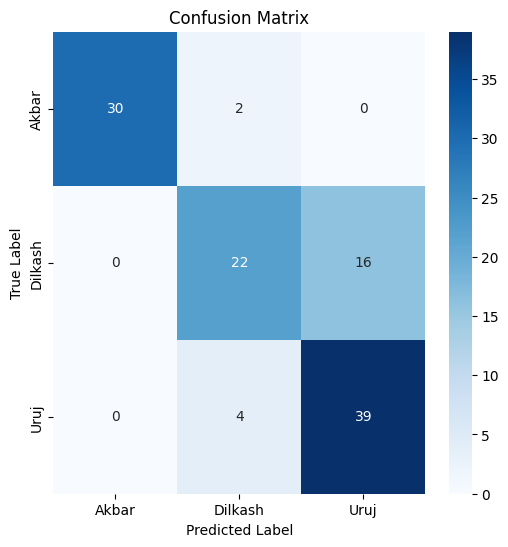

In [101]:
googlenet.eval()  
true_labels = []
predictions = []

with torch.no_grad():
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)

        outputs = googlenet(images)  
        _, preds = torch.max(outputs, 1) 

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
predictions = np.array(predictions)

precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


class_names = ['Akbar','Dilkash', 'Uruj']  
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b-', label='Training Accuracy')
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


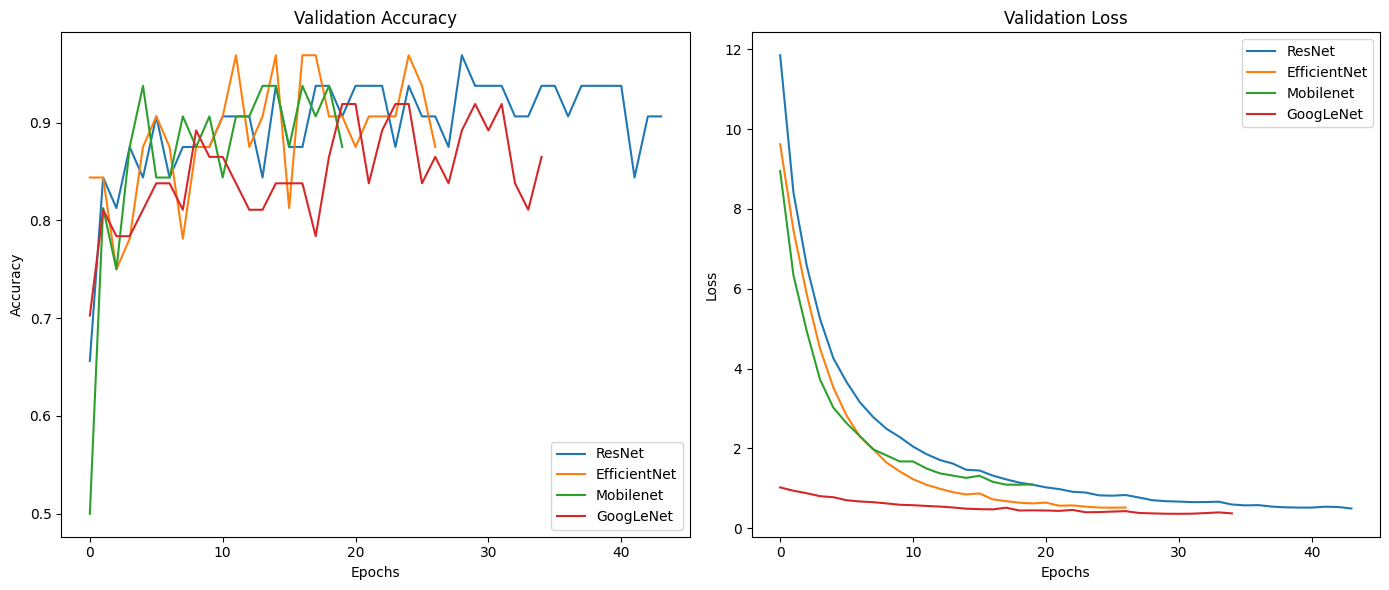

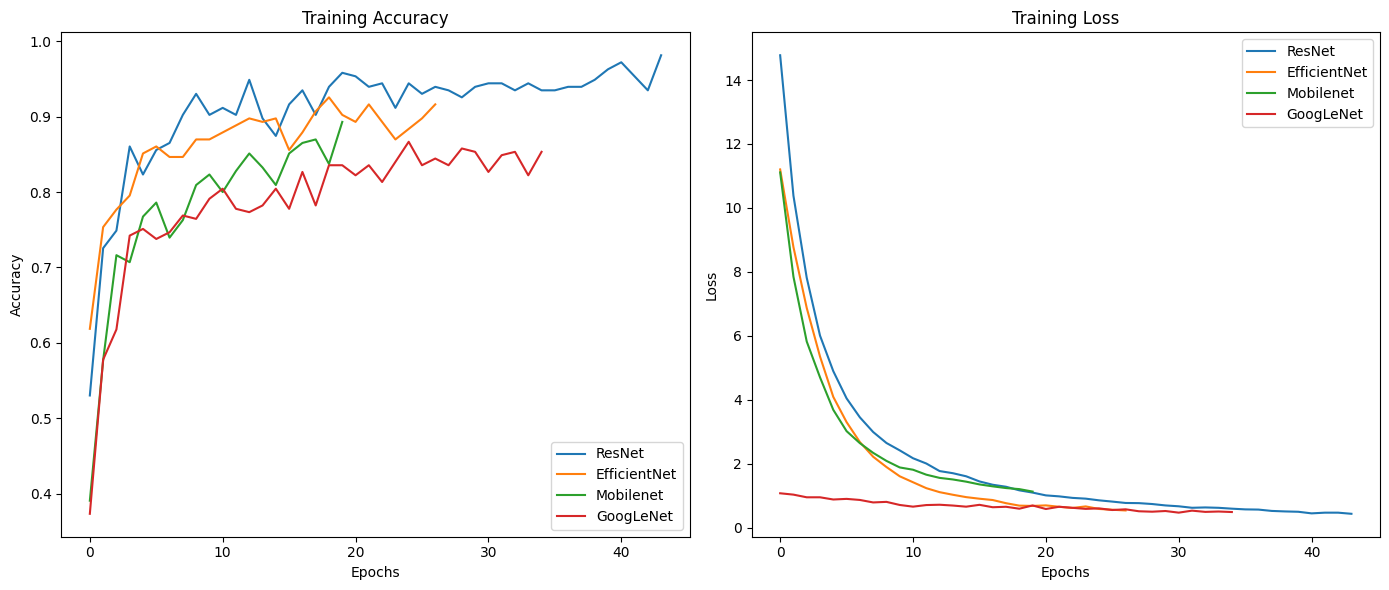

In [102]:
histories = [history, history2, history3,]
model_names = ['ResNet', 'EfficientNet', 'Mobilenet']

class PseudoHistory:
    def __init__(self, train_acc, val_acc, train_loss, val_loss):
        self.history = {
            'accuracy': train_acc,
            'val_accuracy': val_acc,
            'loss': train_loss,
            'val_loss': val_loss
        }


googlenet_history = PseudoHistory(train_accuracies, val_accuracies, train_losses, val_losses)

histories.append(googlenet_history)
model_names.append('GoogLeNet')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_accuracy'], label=model_names[i])
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['val_loss'], label=model_names[i])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(hist.history['accuracy'], label=model_names[i])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(hist.history['loss'], label=model_names[i])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

